# LoC segmentation notebook

This notebook loads a set of images and segments them based on a "segmentation channel" of choice. The structure of the notebook is as follows:

1. Load images
2. Segment
3. Localise segment centroids
4. Unite cell slices over z-stack (equivalent to track over t)
5. Check labelling in Napari

Load necessary Python packages:

In [3]:
import os # this module contains functions for interacting with the operating system (i.e. list files etc)
import glob # good for finding files matching a certain extension
from skimage import io #scikit image data in/out module (for loading/saving images)
import napari # image viewer
import matplotlib.pyplot as plt # figure making module, used to display two images side by side
from tqdm.auto import tqdm # this is a counter that times how long iterative jobs take
import numpy as np # this numerical python module is good for handling images as matrices
import btrack # this is for "tracking" cells through the z-axis

# modules for loading vsi image file format
import javabridge
import bioformats
import bioformats.formatreader as F
from bioformats import metadatatools

## 1. Load images

The first step here is to define a base directory where different images for analysis are stored. By defining the path to this directory as a python variable we will reduce the need for long string input of future image paths. 

In [4]:
base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/Light microscopy/'
print('Here are the experimental data sets contained within base_dir:')
print(os.listdir(base_dir))

Here are the experimental data sets contained within base_dir:
['DAPI-AQP5-proSPC-ZO1', 'DAPI-SPC-PDPN-ZO1', 'DAPI-CAV1-proSPC-ZO1', 'DAPI-NKX21-PDPN-ZO1']


Next we will pick one experiment to work with from the aforementioned directories

In [5]:
expt = 'DAPI-SPC-PDPN-ZO1'
expt_dir = os.path.join(base_dir, expt) # use os to join the names of the two directories together in new python variable

And now we will show the different images from this experiment

In [6]:
print('Here are the image data sets contained within expt_dir:')
image_file_list = glob.glob(os.path.join(expt_dir, '**/*.vsi')) # using glob to find all .vsi files
for image_file in image_file_list:
    folder_up = os.path.basename(os.path.dirname(image_file))
    file_name = os.path.basename(image_file)
    print(f'{folder_up}/{file_name}')

Here are the image data sets contained within expt_dir:
Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi
Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244.vsi
Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246.vsi
Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123.vsi
Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi
Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121.vsi


Select one set of images to work with initially (later we will iterate over all images for bulk segmentation jobs) 

In [8]:
image_dir = 'Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244.vsi'
image_fn = os.path.join(expt_dir, image_dir)

In [9]:
image_fn

'/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/Light microscopy/mono-culture/iAT2AT1/for analysis_20221125/DAPI-SPC-PDPN-ZO1/Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244.vsi'

#### From .vsi file (WIP): 

Load images using a java/python interface. If this doesn't work then open the `.vsi` file in Fiji and save out as `.tif`, then load here. 

In [24]:
javabridge.start_vm(class_path=bioformats.JARS)
with bioformats.ImageReader(image_fn) as reader:
        image_vsi = reader.read()
# javabridge.kill_vm() # running this line means kernel has to reboot before loading another image

14:26:51.959 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.URLReader
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:419)
	at sun.misc.Launcher$AppClassLoader.loadClass(Launcher.java:352)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:352)
	at java.lang.Class.forName0(Native Method)
	at java.lang.Class.forName(Class.java:264)
	at loci.formats.ClassList.parseLine(ClassList.java:196)
	at loci.formats.ClassList.parseFile(ClassList.java:258)
	at loci.formats.ClassList.<init>(ClassList.java:138)
14:26:51.959 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.SlideBook6Reader
java.lang.ClassNotFoundException: loci.formats.in.SlideBook6Reader
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:419)
	at sun.misc.Launcher$AppClassLoader.loadClass(Launc

In [25]:
image_vsi.shape

(2304, 2304, 4)

#### From .tif file: 

In [7]:
%%time 
image_fn = '/mnt/DATA/lung_on_chip/coculture/20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_57.vsi - 001 CF405, CF488, CF561, CF638.tif'
image = io.imread(image_fn)
print(f'Image shape is: {image.shape} (ZXYC)')

Image shape is: (81, 2304, 2304, 4) (ZXYC)
CPU times: user 1.18 s, sys: 1.29 s, total: 2.47 s
Wall time: 2.85 s


In [8]:
image.shape

(81, 2304, 2304, 4)

#### Inspect images before proceeding (optional)

In [18]:
viewer = napari.Viewer() # initiate an instance of the napari viewer 

viewer.add_image(image,
                 channel_axis=-1, 
                scale=(5,1,1))

[<Image layer 'Image' at 0x7f972dd6f580>,
 <Image layer 'Image [1]' at 0x7f98f79c4f10>,
 <Image layer 'Image [2]' at 0x7f98f7949d00>,
 <Image layer 'Image [3]' at 0x7f98f786aee0>]

#### Designate channels as separate python variables

Makes life easier later down the line when you want to segment one slice

In [30]:
mask_input_channel = image[...,3] # picking ch3 as mask input

## 2. Segmentation

Activate GPU (if you have one) and defiune cellpose segmentation model

In [31]:
# print gpu information
!nvcc --version
!nvidia-smi

# load cellpose
from cellpose import core, utils, models, metrics

# check to see if GPU can be used
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# define segmentation model parameters
model = models.Cellpose(gpu=use_GPU, 
                        model_type='cyto') # cytoplasmic segmentation 
channels = [0,0] # this means using a grayscale image for both nuclei and cyto channels (even if not using nuclei, still have to say its same colour [greyscale = 0])

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Fri Jul 21 10:32:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 31%   60C    P2    84W / 300W |  13966MiB / 49140MiB |      1%      Default |
|                               |                      |                  N/A |
+

#### Test segmentation on a frame

Estimated average mask diameter is: 200.00


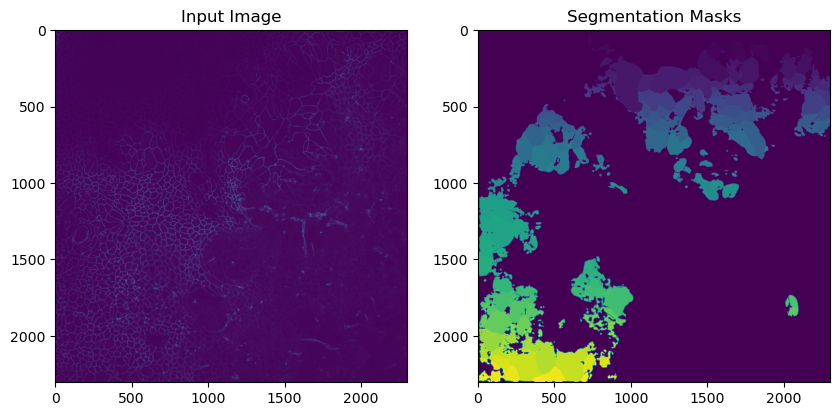

CPU times: user 2.93 s, sys: 335 ms, total: 3.26 s
Wall time: 2.95 s
Rendering frames...


100%|████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.68it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


Rendering frames...


100%|████████████████████████████████████████████████████████| 106/106 [00:13<00:00,  7.64it/s]


Rendering frames...


 86%|████████████████████████████████████████████████        | 181/211 [00:24<00:03,  7.51it/s]
Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_animation/_qt/animation_widget.py", line 163, in _save_callback
    self.animation.animate(**animation_kwargs)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_animation/animation.py", line 196, in animate
    writer = imageio.get_writer(
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/imageio/v2.py", line 190, in get_writer
    return image_file.legacy_get_writer(**kwargs)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/imageio/core/legacy_plugin_wrapper.py", line 165, in legacy_get_writer
    return self._format.get_writer(self._request)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/imageio/core/format.py", line 235, in get_writer
    return self.Writer(self, request)
  File "/home/dayn/minicond

Rendering frames...


 83%|██████████████████████████████████████████████▋         | 151/181 [00:17<00:03,  8.78it/s]


In [34]:
%%time
index = 35  # pick which frame/zslice to test the segmentation on
masks, flows, styles, diams = model.eval(
    mask_input_channel[index],  # input image to segment
    diameter=200,  # set average cell diameter (if left to None then it estimates for you)
    flow_threshold=None,  # optional parameter to increase if cells undersegmented
    channels=channels  # channel input defined above
)

print(f"Estimated average mask diameter is: {diams:.2f}") # print the estimated cell diameter 

# Display input image and masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(mask_input_channel[index])
ax1.set_title("Input Image")
ax2.imshow(masks)
ax2.set_title("Segmentation Masks")
plt.show()

#### Or view segmentation results in napari (optional)

In [43]:
viewer.add_image(masks)

<Image layer 'masks' at 0x7f29bcd6b220>

### Run segmentation over whole image stack

In [49]:
%%time
### define empty mask image array (as a list)
mask_stack = []
### iterate over frames
for frame in tqdm(mask_input_channel, total = len(mask_input_channel)):
    ### run segmentation for single frame
    masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
    ### append segmentation results to empty to mask image list
    mask_stack.append(masks)
# turn mask stack into an image array
mask_stack = np.stack(mask_stack, axis = 0)

  0%|          | 0/81 [00:00<?, ?it/s]

CPU times: user 11min 36s, sys: 1min 53s, total: 13min 29s
Wall time: 12min 34s


In [53]:
viewer.add_labels(mask_stack)

<Labels layer 'mask_stack' at 0x7f29b7fe7340>

Rendering frames...


100%|████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


## 3. Localise objects (cells) prior to uniting them over Z-volume

In [59]:
props = ('axis_major_length', # first define some cell properties 
         'axis_minor_length', # this helps improve the tracking
         'eccentricity',      # by comparing similarities between slices/frames
         'area', 
         'orientation',
         'mean_intensity')

In [60]:
%%time
objects = btrack.utils.segmentation_to_objects(
            segmentation = mask_stack, # set the masks here 
            intensity_image = image, # provide the image so that the mean intensity can be measured
            properties = props, # provide the cell properties to improve tracker 
            use_weighted_centroid = False)
print(f'{len(objects)} cell objects found in {len(mask_input_channel)} frames/z-slices')

[INFO][2023/07/20 03:17:33 pm] Localizing objects from segmentation...
20-Jul-23 15:17:33 - btrack.io._localization - INFO     - Localizing objects from segmentation...
100%|██████████████████████████████████████████████████████████| 81/81 [00:31<00:00,  2.57it/s]
[INFO][2023/07/20 03:18:05 pm] Objects are of type: <class 'dict'>
20-Jul-23 15:18:05 - btrack.io.utils - INFO     - Objects are of type: <class 'dict'>
[INFO][2023/07/20 03:18:06 pm] ...Found 80092 objects in 81 frames.
20-Jul-23 15:18:06 - btrack.io._localization - INFO     - ...Found 80092 objects in 81 frames.


CPU times: user 32.4 s, sys: 84.7 ms, total: 32.5 s
Wall time: 32.4 s


Check that a single-cell object has the correct properties

In [62]:
objects[0]

,ID,x,y,z,t,dummy,states,label,axis_major_length,axis_minor_length,eccentricity,area,orientation,mean_intensity
0,0,11.467066,7.419162,0.0,0,False,7,5,30.070495,15.844388,0.849922,334,-1.246217,"(4,) array"


## 4. Unite/track single-cell objects over whole image stack

In [ ]:
with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure('/home/dayn/analysis/btrack/models/particle_config.json')
        ### set max search radius
        tracker.max_search_radius = 50 
        # use visual features to track
        tracker.features = props
        # append the objects to be tracked
        tracker.append(objects)
        # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
        tracker.volume=((0, mask_input_channel.shape[1]), (0, mask_input_channel.shape[2]), (-1e5, 1e5))
        # track them (in interactive mode)
        tracker.track(tracking_updates =['visual', 'motion'], step_size=10)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # get the tracks as a python list
        tracks_2 = tracker.tracks
        # optional: get the data in a format for napari
        napari_tracks_2, properties, graph = tracker.to_napari()

[INFO][2023/07/20 03:27:02 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
20-Jul-23 15:27:02 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/07/20 03:27:02 pm] Starting BayesianTracker session
20-Jul-23 15:27:02 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/07/20 03:27:02 pm] Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
20-Jul-23 15:27:02 - btrack.config - INFO     - Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
[INFO][2023/07/20 03:27:02 pm] Objects are of type: <class 'list'>
20-Jul-23 15:27:02 - btrack.io.utils - INFO     - Objects are of type: <class 'list'>
[INFO][2023/07/20 03:27:03 pm] Starting tracking... 
20-Jul-23 15:27:03 - btrack.core - INFO     - Starting tracking... 
[INFO][2023/07/20 03:27:03 pm] Update using: ['MOTION', 'VISUAL']
20-Jul-23 15:27:03 - btrack.core - INFO     - Update 

## 5. Check results in Napari

In [ ]:
viewer.add_tracks(napari_tracks, properties, graph)

In [ ]:
from macrohet.notify import send_sms

In [ ]:
send_sms('tracking done')

In [ ]:
print()

### Using masks to focus on apicobasal

Use masks to apply zero average pixel intensity over regions already segmented so that larger segments are focused on the next iteration

In [128]:
frame = mask_stack[40]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


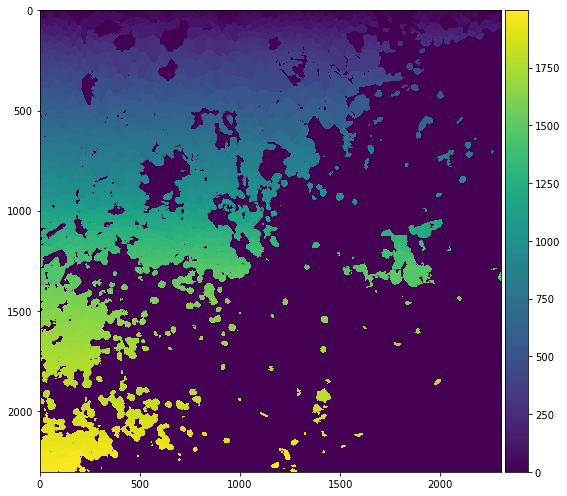

In [129]:
imshow(frame)

In [112]:
import skimage as ski

In [130]:
### binarise 
frame = (frame > 0)

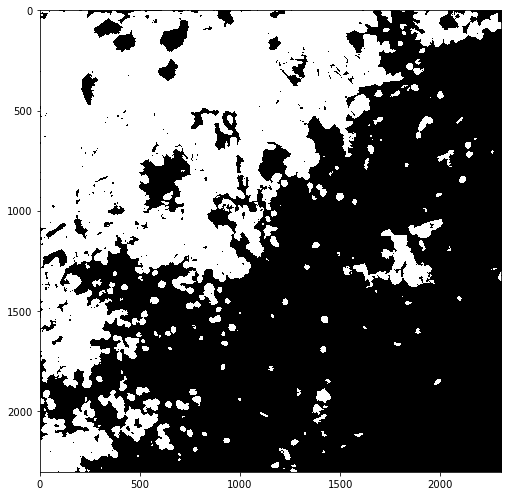

In [131]:
imshow(frame)

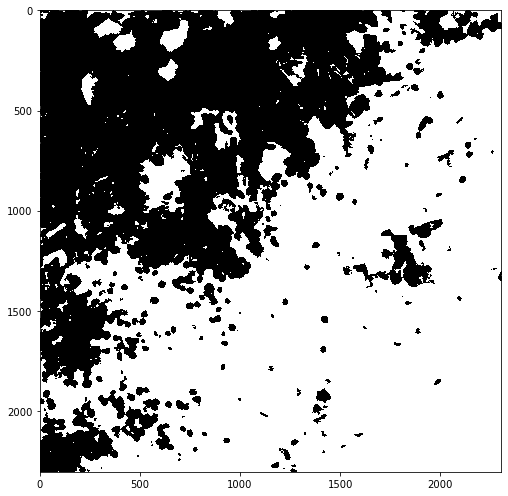

In [114]:
imshow(ski.util.invert(frame))

In [115]:
frame = ski.util.invert(frame)

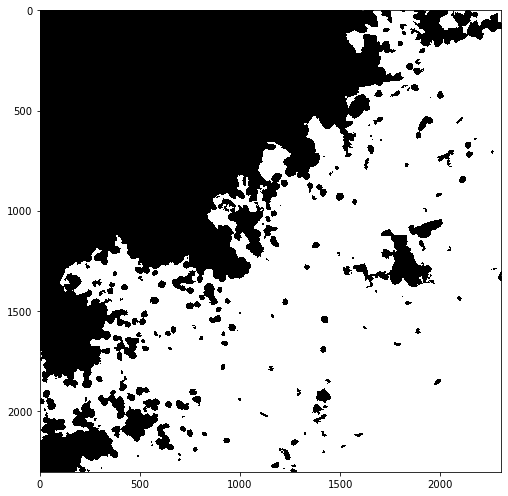

In [116]:
imshow(ski.morphology.remove_small_objects(frame.compute(), min_size=200000))

In [117]:
frame = ski.morphology.remove_small_objects(frame.compute(), min_size=200000)

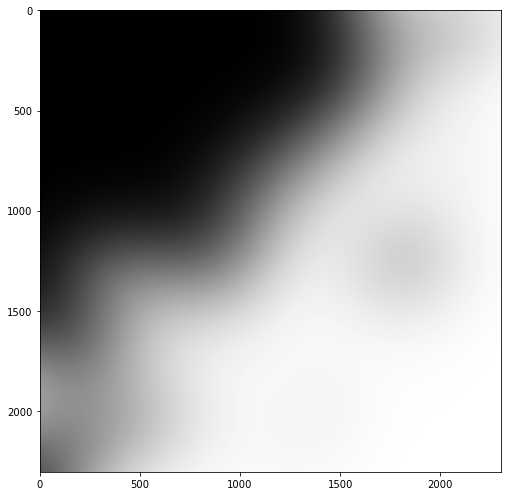

In [118]:
imshow(ski.filters.gaussian(frame, sigma=200, preserve_range=True))

In [119]:
frame = ski.filters.gaussian(frame, sigma=200, preserve_range=True)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


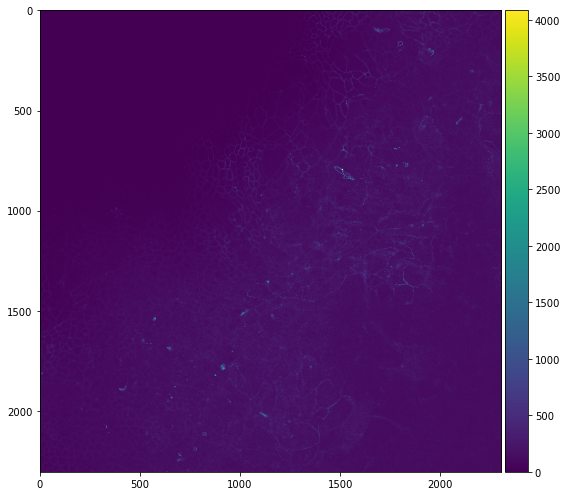

In [120]:
imshow(frame*zo1[40])

In [122]:
frame = frame*zo1[40]

In [123]:
masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: Themes were changed to use evented model with Pydantic's color type rather than the `rgb(x, y, z)`. The `as_dict=True` option will be changed to `as_dict=False` in 0.4.15
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarr

Rendering frame  1 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
IMAGEIO FFMPEG_WRITER WARNING: input image is n

Rendering frame  2 of 199
Rendering frame  3 of 199
Rendering frame  4 of 199
Rendering frame  5 of 199
Rendering frame  6 of 199


[swscaler @ 0x5c510c0] Warning: data is not aligned! This can lead to a speed loss
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0


Rendering frame  7 of 199
Rendering frame  8 of 199
Rendering frame  9 of 199
Rendering frame  10 of 199
Rendering frame  11 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  12 of 199
Rendering frame  13 of 199
Rendering frame  14 of 199
Rendering frame  15 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  16 of 199
Rendering frame  17 of 199
Rendering frame  18 of 199
Rendering frame  19 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  20 of 199
Rendering frame  21 of 199
Rendering frame  22 of 199
Rendering frame  23 of 199
Rendering frame  24 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  25 of 199
Rendering frame  26 of 199
Rendering frame  27 of 199
Rendering frame  28 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  29 of 199
Rendering frame  30 of 199
Rendering frame  31 of 199
Rendering frame  32 of 199
Rendering frame  33 of 199
Rendering frame  34 of 199
Rendering frame  35 of 199
Rendering frame  36 of 199
Rendering frame  37 of 199
Rendering frame  38 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  39 of 199
Rendering frame  40 of 199
Rendering frame  41 of 199
Rendering frame  42 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  43 of 199
Rendering frame  44 of 199
Rendering frame  45 of 199
Rendering frame  46 of 199
Rendering frame  47 of 199
Rendering frame  48 of 199
Rendering frame  49 of 199
Rendering frame  50 of 199
Rendering frame  51 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  52 of 199
Rendering frame  53 of 199
Rendering frame  54 of 199
Rendering frame  55 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  56 of 199
Rendering frame  57 of 199
Rendering frame  58 of 199
Rendering frame  59 of 199
Rendering frame  60 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  61 of 199
Rendering frame  62 of 199
Rendering frame  63 of 199
Rendering frame  64 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  65 of 199
Rendering frame  66 of 199
Rendering frame  67 of 199
Rendering frame  68 of 199
Rendering frame  69 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  70 of 199
Rendering frame  71 of 199
Rendering frame  72 of 199
Rendering frame  73 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  74 of 199
Rendering frame  75 of 199
Rendering frame  76 of 199
Rendering frame  77 of 199
Rendering frame  78 of 199
Rendering frame  79 of 199
Rendering frame  80 of 199
Rendering frame  81 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 199
Rendering frame  83 of 199
Rendering frame  84 of 199
Rendering frame  85 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  86 of 199
Rendering frame  87 of 199
Rendering frame  88 of 199
Rendering frame  89 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  90 of 199
Rendering frame  91 of 199
Rendering frame  92 of 199
Rendering frame  93 of 199
Rendering frame  94 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  95 of 199
Rendering frame  96 of 199
Rendering frame  97 of 199
Rendering frame  98 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  99 of 199
Rendering frame  100 of 199
Rendering frame  101 of 199
Rendering frame  102 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  103 of 199
Rendering frame  104 of 199
Rendering frame  105 of 199
Rendering frame  106 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  107 of 199
Rendering frame  108 of 199
Rendering frame  109 of 199
Rendering frame  110 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  111 of 199
Rendering frame  112 of 199
Rendering frame  113 of 199
Rendering frame  114 of 199
Rendering frame  115 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  116 of 199
Rendering frame  117 of 199
Rendering frame  118 of 199
Rendering frame  119 of 199
Rendering frame  120 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  121 of 199
Rendering frame  122 of 199
Rendering frame  123 of 199
Rendering frame  124 of 199
Rendering frame  125 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  126 of 199
Rendering frame  127 of 199
Rendering frame  128 of 199
Rendering frame  129 of 199
Rendering frame  130 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  131 of 199
Rendering frame  132 of 199
Rendering frame  133 of 199
Rendering frame  134 of 199
Rendering frame  135 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  136 of 199
Rendering frame  137 of 199
Rendering frame  138 of 199
Rendering frame  139 of 199
Rendering frame  140 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  141 of 199
Rendering frame  142 of 199
Rendering frame  143 of 199
Rendering frame  144 of 199
Rendering frame  145 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  146 of 199
Rendering frame  147 of 199
Rendering frame  148 of 199
Rendering frame  149 of 199
Rendering frame  150 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  151 of 199
Rendering frame  152 of 199
Rendering frame  153 of 199
Rendering frame  154 of 199
Rendering frame  155 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  156 of 199
Rendering frame  157 of 199
Rendering frame  158 of 199
Rendering frame  159 of 199
Rendering frame  160 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  161 of 199
Rendering frame  162 of 199
Rendering frame  163 of 199
Rendering frame  164 of 199
Rendering frame  165 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  166 of 199
Rendering frame  167 of 199
Rendering frame  168 of 199
Rendering frame  169 of 199
Rendering frame  170 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  171 of 199
Rendering frame  172 of 199
Rendering frame  173 of 199
Rendering frame  174 of 199
Rendering frame  175 of 199
Rendering frame  176 of 199
Rendering frame  177 of 199
Rendering frame  178 of 199
Rendering frame  179 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  180 of 199
Rendering frame  181 of 199
Rendering frame  182 of 199
Rendering frame  183 of 199
Rendering frame  184 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  185 of 199
Rendering frame  186 of 199
Rendering frame  187 of 199
Rendering frame  188 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  189 of 199
Rendering frame  190 of 199
Rendering frame  191 of 199
Rendering frame  192 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  193 of 199
Rendering frame  194 of 199
Rendering frame  195 of 199
Rendering frame  196 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  197 of 199
Rendering frame  198 of 199
Rendering frame  199 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


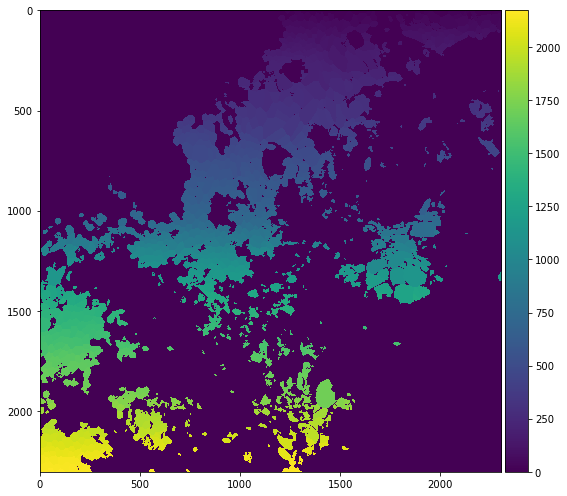

In [126]:
imshow(masks)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


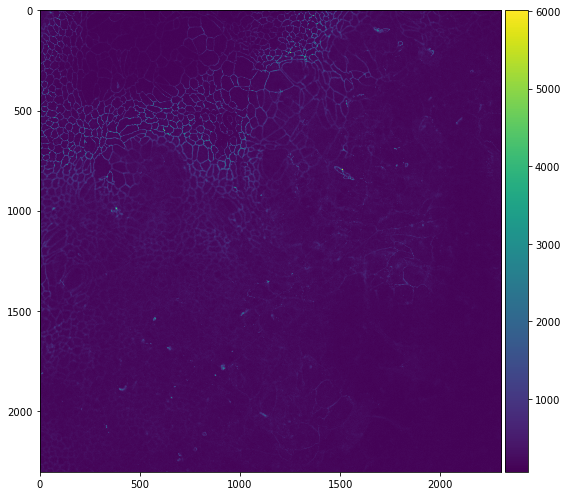

In [82]:
imshow(zo1[40])

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


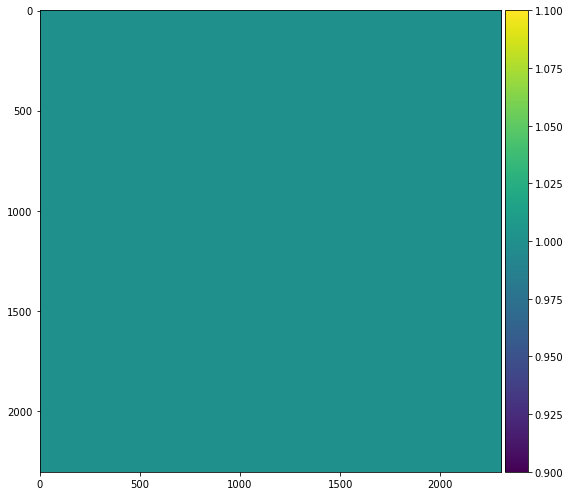

In [202]:
imshow(basal_masks)

In [204]:
basal_mask_stack = []
apical_mask_stack = []
masks_stack = []
for frame in tqdm(zo1):
        ### get basal mask
        basal_masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
        ### append to mask stack
        basal_mask_stack.append(basal_masks)
        ### binarise 
        basal_masks = (basal_masks > 0)
        ### invert the binary image to zero regions with lots of masks
        basal_masks = ski.util.invert(basal_masks)
        ### remove small holes from mask
        basal_masks = ski.morphology.remove_small_holes(basal_masks, area_threshold=200000)
        ### remove small objects from mask
        basal_masks = ski.morphology.remove_small_objects(basal_masks, min_size=200000)
        ### now gaussian blur to make a mask of broadly unsegmented region
        basal_masks = ski.filters.gaussian(basal_masks, sigma=200, preserve_range=True)
        ### now multiply that mask by the zo1 image 
        apical_frame = frame * basal_masks
        ### now segment that image
        apical_masks, flows, styles, diams = model.eval(apical_frame, diameter=300, flow_threshold=None, channels=channels)
        ### append to apical mask stack
        apical_mask_stack.append(apical_masks)
        ### create new superimposed mask stack
        masks = apical_masks + basal_masks
        masks_stack.append(masks)
mask_stack = da.stack(masks_stack, axis = 0).astype('u2')
apical_mask_stack = da.stack(apical_mask_stack, axis = 0)
basal_mask_stack = da.stack(basal_mask_stack, axis = 0)

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: Ru

In [206]:
viewer = napari.Viewer()

viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'yellow', blending = 'additive')
viewer.add_labels(mask_stack)
viewer.add_labels(basal_mask_stack)
viewer.add_labels(apical_mask_stack)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'apical_mask_stack' at 0x7f4e85649fd0>

# A little post-processing

In [213]:
apical_masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [253]:
pp_apical_masks = []
pp_basal_masks = []
for apical_mask, basal_mask in tqdm(zip(apical_mask_stack, basal_mask_stack), total = len(basal_mask_stack)):
    apical_mask = ski.morphology.remove_small_objects(apical_mask.compute(), min_size=4000)
    basal_mask = ski.morphology.remove_small_objects(basal_mask.compute(), min_size = 2000)
    
    pp_apical_masks.append(apical_mask)
    pp_basal_masks.append(basal_mask)
pp_apical_masks = da.stack(pp_apical_masks, axis =0)
pp_basal_masks = da.stack(pp_basal_masks, axis =0)

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


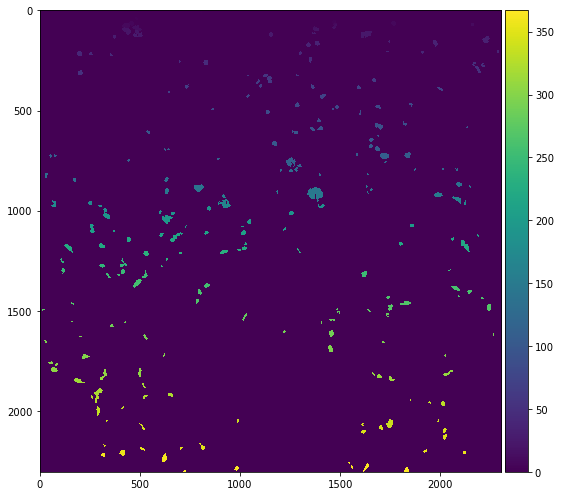

In [256]:
imshow(pp_basal_masks[50])

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


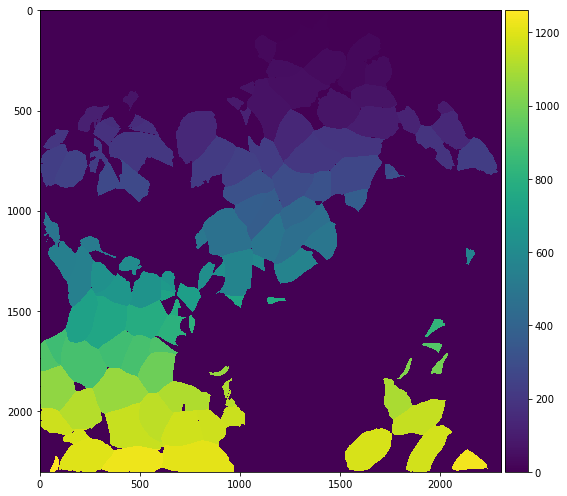

In [244]:
imshow(pp_apical_masks[50])

In [266]:
imsave('/mnt/DATA/sandbox/lung_on_chip/pp_apical_masks.tif', pp_apical_masks)
imsave('/mnt/DATA/sandbox/lung_on_chip/pp_basal_masks.tif', pp_basal_masks)

/tmp/ipykernel_339998/4293202420.py:1: UserWarning: /mnt/DATA/sandbox/lung_on_chip/pp_apical_masks.tif is a low contrast image
  imsave('/mnt/DATA/sandbox/lung_on_chip/pp_apical_masks.tif', pp_apical_masks)
/tmp/ipykernel_339998/4293202420.py:2: UserWarning: /mnt/DATA/sandbox/lung_on_chip/pp_basal_masks.tif is a low contrast image
  imsave('/mnt/DATA/sandbox/lung_on_chip/pp_basal_masks.tif', pp_basal_masks)


In [267]:

viewer = napari.Viewer()

viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'yellow', blending = 'additive')
# viewer.add_labels(mask_stack)
viewer.add_labels(pp_basal_masks)
viewer.add_labels(pp_apical_masks)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_339998/3056315190.py", line 1, in <cell line: 1>
    viewer = napari.Viewer()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/viewer.py", line 57, in __init__
    self._window = Window(self, show=show)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 430, in __init__
    self._add_menus()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py", line 193, in _add_menus
    self._add_menus_bkp()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py", line 178, in _add_menus
    def register_dock_widget(widget, menu:str, *args, **kwargs) -> Callable:
  File "/home/dayn/miniconda3/envs/aero

# Reloading images

In [12]:
%%time
image = imread('/mnt/DATA/sandbox/lung_on_chip/20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_57.vsi - 001 CF405, CF488, CF561, CF638.tif')
zo1 = image[...,3]
dapi = image[...,0]
apical_mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/pp_apical_masks.tif')
basal_mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/pp_basal_masks.tif')

CPU times: user 1.12 s, sys: 1.57 s, total: 2.69 s
Wall time: 2.68 s


#### Little more post processessing 

In [22]:
pp_apical_masks = []
pp_basal_masks = []
for apical_mask, basal_mask in tqdm(zip(apical_mask_stack, basal_mask_stack), total = len(basal_mask_stack)):
    apical_mask = ski.morphology.remove_small_objects(apical_mask, min_size=4000)
    basal_mask = ski.morphology.remove_small_objects(basal_mask, min_size = 500)
    
    pp_apical_masks.append(apical_mask)
    pp_basal_masks.append(basal_mask)
pp_apical_masks = da.stack(pp_apical_masks, axis =0)
pp_basal_masks = da.stack(pp_basal_masks, axis =0)

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


In [23]:
viewer = napari.Viewer()
viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'yellow', blending = 'additive')
# viewer.add_labels(mask_stack)
viewer.add_labels(pp_basal_masks)
viewer.add_labels(pp_apical_masks)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'pp_apical_masks' at 0x7efd4ca1df70>

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: Themes were changed to use evented model with Pydantic's color type rather than the `rgb(x, y, z)`. The `as_dict=True` option will be changed to `as_dict=False` in 0.4.15
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarr

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  1 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
IMAGEIO FFMPEG_WRITER WARNING: input image is n

Rendering frame  2 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  3 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  4 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  5 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  6 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  7 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  8 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  9 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  10 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  11 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  12 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  13 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  14 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  15 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  16 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  17 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  18 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  19 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  20 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  21 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  23 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  24 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  25 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  26 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  27 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  28 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  29 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  30 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  31 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  32 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  33 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  34 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  35 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  36 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  37 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  38 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  39 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  40 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  41 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  43 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  44 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  45 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  46 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  47 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  48 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  49 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  50 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  51 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  52 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  53 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  54 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  55 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  56 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  57 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  58 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  59 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  60 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  61 of 61


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 595
Rendering frame  2 of 595


[swscaler @ 0x670dec0] Warning: data is not aligned! This can lead to a speed loss
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0


Rendering frame  3 of 595
Rendering frame  4 of 595
Rendering frame  5 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  6 of 595
Rendering frame  7 of 595
Rendering frame  8 of 595
Rendering frame  9 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  10 of 595
Rendering frame  11 of 595
Rendering frame  12 of 595
Rendering frame  13 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  14 of 595
Rendering frame  15 of 595
Rendering frame  16 of 595
Rendering frame  17 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  18 of 595
Rendering frame  19 of 595
Rendering frame  20 of 595
Rendering frame  21 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  22 of 595
Rendering frame  23 of 595
Rendering frame  24 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  25 of 595
Rendering frame  26 of 595
Rendering frame  27 of 595
Rendering frame  28 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  29 of 595
Rendering frame  30 of 595
Rendering frame  31 of 595
Rendering frame  32 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  33 of 595
Rendering frame  34 of 595
Rendering frame  35 of 595
Rendering frame  36 of 595
Rendering frame  37 of 595
Rendering frame  38 of 595
Rendering frame  39 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  40 of 595
Rendering frame  41 of 595
Rendering frame  42 of 595
Rendering frame  43 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  44 of 595
Rendering frame  45 of 595
Rendering frame  46 of 595
Rendering frame  47 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  48 of 595
Rendering frame  49 of 595
Rendering frame  50 of 595
Rendering frame  51 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  52 of 595
Rendering frame  53 of 595
Rendering frame  54 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  55 of 595
Rendering frame  56 of 595
Rendering frame  57 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  58 of 595
Rendering frame  59 of 595
Rendering frame  60 of 595
Rendering frame  61 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  62 of 595
Rendering frame  63 of 595
Rendering frame  64 of 595
Rendering frame  65 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  66 of 595
Rendering frame  67 of 595
Rendering frame  68 of 595
Rendering frame  69 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  70 of 595
Rendering frame  71 of 595
Rendering frame  72 of 595
Rendering frame  73 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  74 of 595
Rendering frame  75 of 595
Rendering frame  76 of 595
Rendering frame  77 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  78 of 595
Rendering frame  79 of 595
Rendering frame  80 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  81 of 595
Rendering frame  82 of 595
Rendering frame  83 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  84 of 595
Rendering frame  85 of 595
Rendering frame  86 of 595
Rendering frame  87 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  88 of 595
Rendering frame  89 of 595
Rendering frame  90 of 595
Rendering frame  91 of 595
Rendering frame  92 of 595
Rendering frame  93 of 595
Rendering frame  94 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  95 of 595
Rendering frame  96 of 595
Rendering frame  97 of 595
Rendering frame  98 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  99 of 595
Rendering frame  100 of 595
Rendering frame  101 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  102 of 595
Rendering frame  103 of 595
Rendering frame  104 of 595
Rendering frame  105 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  106 of 595
Rendering frame  107 of 595
Rendering frame  108 of 595
Rendering frame  109 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  110 of 595
Rendering frame  111 of 595
Rendering frame  112 of 595
Rendering frame  113 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  114 of 595
Rendering frame  115 of 595
Rendering frame  116 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  117 of 595
Rendering frame  118 of 595
Rendering frame  119 of 595
Rendering frame  120 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  121 of 595
Rendering frame  122 of 595
Rendering frame  123 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  124 of 595
Rendering frame  125 of 595
Rendering frame  126 of 595
Rendering frame  127 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  128 of 595
Rendering frame  129 of 595
Rendering frame  130 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  131 of 595
Rendering frame  132 of 595
Rendering frame  133 of 595
Rendering frame  134 of 595
Rendering frame  135 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  136 of 595
Rendering frame  137 of 595
Rendering frame  138 of 595
Rendering frame  139 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  140 of 595
Rendering frame  141 of 595
Rendering frame  142 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  143 of 595
Rendering frame  144 of 595
Rendering frame  145 of 595
Rendering frame  146 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  147 of 595
Rendering frame  148 of 595
Rendering frame  149 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  150 of 595
Rendering frame  151 of 595
Rendering frame  152 of 595
Rendering frame  153 of 595
Rendering frame  154 of 595
Rendering frame  155 of 595
Rendering frame  156 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  157 of 595
Rendering frame  158 of 595
Rendering frame  159 of 595
Rendering frame  160 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  161 of 595
Rendering frame  162 of 595
Rendering frame  163 of 595
Rendering frame  164 of 595
Rendering frame  165 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  166 of 595
Rendering frame  167 of 595
Rendering frame  168 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  169 of 595
Rendering frame  170 of 595
Rendering frame  171 of 595
Rendering frame  172 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  173 of 595
Rendering frame  174 of 595
Rendering frame  175 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  176 of 595
Rendering frame  177 of 595
Rendering frame  178 of 595
Rendering frame  179 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  180 of 595
Rendering frame  181 of 595
Rendering frame  182 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  183 of 595
Rendering frame  184 of 595
Rendering frame  185 of 595
Rendering frame  186 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  187 of 595
Rendering frame  188 of 595
Rendering frame  189 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  190 of 595
Rendering frame  191 of 595
Rendering frame  192 of 595
Rendering frame  193 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  194 of 595
Rendering frame  195 of 595
Rendering frame  196 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  197 of 595
Rendering frame  198 of 595
Rendering frame  199 of 595
Rendering frame  200 of 595
Rendering frame  201 of 595
Rendering frame  202 of 595
Rendering frame  203 of 595
Rendering frame  204 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  205 of 595
Rendering frame  206 of 595
Rendering frame  207 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  208 of 595
Rendering frame  209 of 595
Rendering frame  210 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  211 of 595
Rendering frame  212 of 595
Rendering frame  213 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  214 of 595
Rendering frame  215 of 595
Rendering frame  216 of 595
Rendering frame  217 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  218 of 595
Rendering frame  219 of 595
Rendering frame  220 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  221 of 595
Rendering frame  222 of 595
Rendering frame  223 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  224 of 595
Rendering frame  225 of 595
Rendering frame  226 of 595
Rendering frame  227 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  228 of 595
Rendering frame  229 of 595
Rendering frame  230 of 595
Rendering frame  231 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  232 of 595
Rendering frame  233 of 595
Rendering frame  234 of 595
Rendering frame  235 of 595
Rendering frame  236 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  237 of 595
Rendering frame  238 of 595
Rendering frame  239 of 595
Rendering frame  240 of 595
Rendering frame  241 of 595
Rendering frame  242 of 595
Rendering frame  243 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  244 of 595
Rendering frame  245 of 595
Rendering frame  246 of 595
Rendering frame  247 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  248 of 595
Rendering frame  249 of 595
Rendering frame  250 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  251 of 595
Rendering frame  252 of 595
Rendering frame  253 of 595
Rendering frame  254 of 595
Rendering frame  255 of 595
Rendering frame  256 of 595
Rendering frame  257 of 595
Rendering frame  258 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  259 of 595
Rendering frame  260 of 595
Rendering frame  261 of 595
Rendering frame  262 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  263 of 595
Rendering frame  264 of 595
Rendering frame  265 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  266 of 595
Rendering frame  267 of 595
Rendering frame  268 of 595
Rendering frame  269 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  270 of 595
Rendering frame  271 of 595
Rendering frame  272 of 595
Rendering frame  273 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  274 of 595
Rendering frame  275 of 595
Rendering frame  276 of 595
Rendering frame  277 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  278 of 595
Rendering frame  279 of 595
Rendering frame  280 of 595
Rendering frame  281 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  282 of 595
Rendering frame  283 of 595
Rendering frame  284 of 595
Rendering frame  285 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  286 of 595
Rendering frame  287 of 595
Rendering frame  288 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  289 of 595
Rendering frame  290 of 595
Rendering frame  291 of 595
Rendering frame  292 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  293 of 595
Rendering frame  294 of 595
Rendering frame  295 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  296 of 595
Rendering frame  297 of 595
Rendering frame  298 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  299 of 595
Rendering frame  300 of 595
Rendering frame  301 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  302 of 595
Rendering frame  303 of 595
Rendering frame  304 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  305 of 595
Rendering frame  306 of 595
Rendering frame  307 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  308 of 595
Rendering frame  309 of 595
Rendering frame  310 of 595
Rendering frame  311 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  312 of 595
Rendering frame  313 of 595
Rendering frame  314 of 595
Rendering frame  315 of 595
Rendering frame  316 of 595
Rendering frame  317 of 595
Rendering frame  318 of 595
Rendering frame  319 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  320 of 595
Rendering frame  321 of 595
Rendering frame  322 of 595
Rendering frame  323 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  324 of 595
Rendering frame  325 of 595
Rendering frame  326 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  327 of 595
Rendering frame  328 of 595
Rendering frame  329 of 595
Rendering frame  330 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  331 of 595
Rendering frame  332 of 595
Rendering frame  333 of 595
Rendering frame  334 of 595
Rendering frame  335 of 595
Rendering frame  336 of 595
Rendering frame  337 of 595
Rendering frame  338 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  339 of 595
Rendering frame  340 of 595
Rendering frame  341 of 595
Rendering frame  342 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  343 of 595
Rendering frame  344 of 595
Rendering frame  345 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  346 of 595
Rendering frame  347 of 595
Rendering frame  348 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  349 of 595
Rendering frame  350 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  351 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  352 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  353 of 595
Rendering frame  354 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  355 of 595
Rendering frame  356 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  357 of 595
Rendering frame  358 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  359 of 595
Rendering frame  360 of 595
Rendering frame  361 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  362 of 595
Rendering frame  363 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  364 of 595
Rendering frame  365 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  366 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  367 of 595
Rendering frame  368 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  369 of 595
Rendering frame  370 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  371 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  372 of 595
Rendering frame  373 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  374 of 595
Rendering frame  375 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  376 of 595
Rendering frame  377 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  378 of 595
Rendering frame  379 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  380 of 595
Rendering frame  381 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  382 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  383 of 595
Rendering frame  384 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  385 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  386 of 595
Rendering frame  387 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  388 of 595
Rendering frame  389 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  390 of 595
Rendering frame  391 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  392 of 595
Rendering frame  393 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  394 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  395 of 595
Rendering frame  396 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  397 of 595
Rendering frame  398 of 595
Rendering frame  399 of 595
Rendering frame  400 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  401 of 595
Rendering frame  402 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  403 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  404 of 595
Rendering frame  405 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  406 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  407 of 595
Rendering frame  408 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  409 of 595
Rendering frame  410 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  411 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  412 of 595
Rendering frame  413 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  414 of 595
Rendering frame  415 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  416 of 595
Rendering frame  417 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  418 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  419 of 595
Rendering frame  420 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  421 of 595
Rendering frame  422 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  423 of 595
Rendering frame  424 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  425 of 595
Rendering frame  426 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  427 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  428 of 595
Rendering frame  429 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  430 of 595
Rendering frame  431 of 595
Rendering frame  432 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  433 of 595
Rendering frame  434 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  435 of 595
Rendering frame  436 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  437 of 595
Rendering frame  438 of 595
Rendering frame  439 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  440 of 595
Rendering frame  441 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  442 of 595
Rendering frame  443 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  444 of 595
Rendering frame  445 of 595
Rendering frame  446 of 595
Rendering frame  447 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  448 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  449 of 595
Rendering frame  450 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  451 of 595
Rendering frame  452 of 595
Rendering frame  453 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  454 of 595
Rendering frame  455 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  456 of 595
Rendering frame  457 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  458 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  459 of 595
Rendering frame  460 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  461 of 595
Rendering frame  462 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  463 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  464 of 595
Rendering frame  465 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  466 of 595
Rendering frame  467 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  468 of 595
Rendering frame  469 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  470 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  471 of 595
Rendering frame  472 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  473 of 595
Rendering frame  474 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  475 of 595
Rendering frame  476 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  477 of 595
Rendering frame  478 of 595
Rendering frame  479 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  480 of 595
Rendering frame  481 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  482 of 595
Rendering frame  483 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  484 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  485 of 595
Rendering frame  486 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  487 of 595
Rendering frame  488 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  489 of 595
Rendering frame  490 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  491 of 595
Rendering frame  492 of 595
Rendering frame  493 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  494 of 595
Rendering frame  495 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  496 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  497 of 595
Rendering frame  498 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  499 of 595
Rendering frame  500 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  501 of 595
Rendering frame  502 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  503 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  504 of 595
Rendering frame  505 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  506 of 595
Rendering frame  507 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  508 of 595
Rendering frame  509 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  510 of 595
Rendering frame  511 of 595
Rendering frame  512 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  513 of 595
Rendering frame  514 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  515 of 595
Rendering frame  516 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  517 of 595
Rendering frame  518 of 595
Rendering frame  519 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  520 of 595
Rendering frame  521 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  522 of 595
Rendering frame  523 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  524 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  525 of 595
Rendering frame  526 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  527 of 595
Rendering frame  528 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  529 of 595
Rendering frame  530 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  531 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  532 of 595
Rendering frame  533 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  534 of 595
Rendering frame  535 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  536 of 595
Rendering frame  537 of 595
Rendering frame  538 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  539 of 595
Rendering frame  540 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  541 of 595
Rendering frame  542 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  543 of 595
Rendering frame  544 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  545 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  546 of 595
Rendering frame  547 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  548 of 595
Rendering frame  549 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  550 of 595
Rendering frame  551 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


of 595
Rendering frame  552 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  553 of 595
Rendering frame  554 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  555 of 595
Rendering frame  556 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  557 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  558 of 595
Rendering frame  559 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  560 of 595
Rendering frame  561 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  562 of 595
Rendering frame  563 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  564 of 595
Rendering frame  565 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  566 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  567 of 595
Rendering frame  568 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  569 of 595
Rendering frame  570 of 595
Rendering frame  571 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  572 of 595
Rendering frame  573 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  574 of 595
Rendering frame  575 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  576 of 595
Rendering frame  577 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  578 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  579 of 595
Rendering frame  580 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  581 of 595
Rendering frame  582 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  583 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  584 of 595
Rendering frame  585 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  586 of 595
Rendering frame  587 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  588 of 595
Rendering frame  589 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  590 of 595
Rendering frame  591 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  592 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  593 of 595
Rendering frame  594 of 595


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  595 of 595


In [24]:
pp_basal_masks

dask.array<stack, shape=(81, 2304, 2304), dtype=uint16, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>

In [25]:
pp_apical_masks

dask.array<stack, shape=(81, 2304, 2304), dtype=uint16, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>